In [1]:
# Importing libraries
import sys
sys.path.insert(0,
                '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Tau_classification/')

from base import *
from constants import *

In [2]:
sys.path.insert(0,
                '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Tuning_parameters/')

from tuning import * 
from extra_metrics_training import *
from tuning_constants import *

In [3]:
import pandas as pd
import numpy as np 
import random 

from sklearn import preprocessing 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [4]:
import joblib

In [5]:
# Importing training files
path = "C:/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Tau_classification/Untrained/Training_data/screening_classifier/"
filename = "training.txt"

# Create tau database object
s_data = TauDataBase(path=path,
                     filename=filename) 

# Prepping data to train screening classifier
s_data.classifier1_prep()

# Check data
print(s_data.c1_data['Class'].value_counts())
print(s_data.c1_X_train.shape)

Non_tau    12006
Tau         9827
Name: Class, dtype: int64
(21833, 54)


In [10]:
rf_random = RandomizedSearchCV(pipeline,
                               param_distributions=random_grid, 
                               n_iter=100,
                               cv=10,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1,
                               refit='PR_AUC',
                               scoring={
                                'PR_AUC': precision_recall_auc_screening,
                                'roc_auc_ovr_weighted': 'roc_auc_ovr_weighted',
                                'roc_auc_ovo': 'roc_auc_ovo',
                                'balanced_accuracy': 'balanced_accuracy',
                                'f1_weighted': 'f1_weighted',
                                'NT_accuracy': NT_acc,
                                'T_accuracy': T_acc,
                                'NT_as_T': NT_as_T,
                                'T_as_NT': T_as_NT
                                        }
                                        )

rf_random.fit(s_data.c1_X_train,
              s_data.c1_Y_train)


print(rf_random.best_score_)
print(rf_random.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
0.9911478458271097
{'selector__n_features_to_select': 46, 'clf__sampling_strategy': 'auto', 'clf__random_state': 42, 'clf__n_estimators': 600, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_samples': None, 'clf__max_features': 1, 'clf__max_depth': None, 'clf__class_weight': 'balanced'}


In [11]:
# save object using joblib
joblib.dump(rf_random, 'screening_random_search_updated3.sav')

['screening_random_search_updated3.sav']

In [12]:
# Digging into more details
print("PR-AUC:",
      rf_random.cv_results_['mean_test_PR_AUC'][rf_random.best_index_]*100)

print("ROC-AUC:",
      rf_random.cv_results_['mean_test_roc_auc_ovo'][rf_random.best_index_]*100)

print("ROC-AUC_OVR_weighted:",
      rf_random.cv_results_['mean_test_roc_auc_ovr_weighted'][rf_random.best_index_]*100)

print("Balanced accuracy:",
      rf_random.cv_results_['mean_test_balanced_accuracy'][rf_random.best_index_]*100)

print("F1_weighted:",
      rf_random.cv_results_['mean_test_f1_weighted'][rf_random.best_index_]*100)

print("Tau accuracy:",
      rf_random.cv_results_['mean_test_T_accuracy'][rf_random.best_index_]*100)

print("Non-tau accuracy:",
      rf_random.cv_results_['mean_test_NT_accuracy'][rf_random.best_index_]*100)


print("Classified Tau as non-tau:",
      rf_random.cv_results_['mean_test_T_as_NT'][rf_random.best_index_]*100)

print("Classified non-tau as tau:",
      rf_random.cv_results_['mean_test_NT_as_T'][rf_random.best_index_]*100)

PR-AUC: 99.11478458271097
ROC-AUC: 99.18705409758287
ROC-AUC_OVR_weighted: 99.18705409758287
Balanced accuracy: 95.75315647997682
F1_weighted: 95.50297382158955
Tau accuracy: 97.75140732575991
Non-tau accuracy: 93.75490563419373
Classified Tau as non-tau: 2.2485926742400855
Classified non-tau as tau: 6.245094365806271


{'selector__n_features_to_select': 46, 'clf__sampling_strategy': 'auto', 'clf__random_state': 42, 'clf__n_estimators': 600, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_samples': None, 'clf__max_features': 1, 'clf__max_depth': None, 'clf__class_weight': 'balanced'}



In [8]:
screening_classifier_hyperparams = [
    ('normalizer', MinMaxScaler()),
    ('selector', RFE(RandomForestClassifier(
        random_state=42),
        n_features_to_select=46)),
    ('clf', BalancedRandomForestClassifier(
        random_state=42,
        sampling_strategy='auto',
        n_estimators=600,
        min_samples_split=2,
        min_samples_leaf=2,
        max_features=1,
        max_depth=None,
        max_samples=None,
        class_weight='balanced'))]
        
# 10-fold cross validation
model = ScreeningClassifierTuning(hyperparameters=screening_classifier_hyperparams)



In [9]:
model.find_bestparameters(X=s_data.c1_X_train,
                          Y=s_data.c1_Y_train)
model.best_parameters

{0: (0.5302233604561282,
  0.9729190236439459,
  0.9761526491904832,
  0.9697699139605884),
 1: (0.4553929723271362,
  0.9672750402144017,
  0.9581882133696038,
  0.9766895678675984)}

In [11]:
model.cv_withthresholding(best_parameters=model.best_parameters,
                          X=s_data.c1_X_train,
                          Y=s_data.c1_Y_train,
                          X_location=s_data.c1_train_location)


In [12]:
# Confusion matrix across 10 folds, WITH thresholding 
print('with thresholding (non-calibrated) ACC :', mean(model.cv_accuraciesT)*100)
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)
print('Weighted avg F1 ',
      mean([i['weighted avg']['f1-score'] for i in model.cv_reportsT])*100)
print("--------------------------")
C_t = sum(model.cv_confusion_matricesT)
final_cm_t = C_t.astype('float') / C_t.sum(axis=1)[:, np.newaxis]*100
print(C_t)
print(final_cm_t)
print("--------------------------")
print("Non_tau accuracy", final_cm_t[0][0])
print("Tau accuracy", final_cm_t[1][1])

print('------------------------------')
# F1-score per class:
print('Non_tau f1-score ',
      mean([i['Non_tau']['f1-score'] for i in model.cv_reportsT])*100)
print('Non_tau precision ',
      mean([i['Non_tau']['precision'] for i in model.cv_reportsT])*100)
print('Non_tau recall ',
      mean([i['Non_tau']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Tau f1-score ',
      mean([i['Tau']['f1-score'] for i in model.cv_reportsT])*100)
print('Tau precision ',
      mean([i['Tau']['precision'] for i in model.cv_reportsT])*100)
print('Tau recall ',
      mean([i['Tau']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reportsT])*100)

with thresholding (non-calibrated) ACC : 95.64416479655493
Macro avg F1  95.35360503169731
Weighted avg F1  95.34433182163461
--------------------------
[[11170   811]
 [  187  9629]]
[[93.230949    6.769051  ]
 [ 1.90505297 98.09494703]]
--------------------------
Non_tau accuracy 93.23094900258742
Tau accuracy 98.09494702526487
------------------------------
Non_tau f1-score  95.2445480574145
Non_tau precision  98.37934168156607
Non_tau recall  93.19339729695068
--------------------------
Tau f1-score  95.46266200598015
Tau precision  93.53591591035075
Tau recall  98.09493229615919
--------------------------
Macro avg precision 95.95762879595841
Macro avg recall  95.64416479655493


In [13]:
model.cv_nothresholding(X=s_data.c1_X_train,
                        Y=s_data.c1_Y_train,
                        X_location= s_data.c1_train_location)

In [14]:
#Confusion matrix across 10 folds, WITHOUT thresholding 
print('with no thresholding:',
      mean(model.cv_accuracies)*100)
print('Macro avg F1 ',
      mean([i['macro avg']['f1-score'] for i in model.cv_reports])*100)
print('Weighted avg F1 ',
      mean([i['weighted avg']['f1-score'] for i in model.cv_reports])*100)
print("--------------------------")
C = sum(model.cv_confusion_matrices)
final_cm = C.astype('float') / C.sum(axis=1)[:, np.newaxis]*100 
print(C)
print(final_cm)
print("--------------------------")
print("Non_tau accuracy", final_cm[0][0])
print("Tau accuracy", final_cm[1][1])

print("--------------------------")
# F1-score per class: 
print('non_tau f1-score ',
      mean([i['Non_tau']['f1-score'] for i in model.cv_reports])*100)
print('tau f1-score ',
      mean([i['Tau']['f1-score'] for i in model.cv_reports])*100)
print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reports])*100)
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reports])*100)

with no thresholding: 95.75315647997682
Macro avg F1  95.50643809603123
Weighted avg F1  95.50297382158955
--------------------------
[[11256   750]
 [  221  9606]]
[[93.75312344  6.24687656]
 [ 2.24890608 97.75109392]]
--------------------------
Non_tau accuracy 93.75312343828087
Tau accuracy 97.75109392490077
--------------------------
non_tau f1-score  95.47299585532522
tau f1-score  95.53988033673726
--------------------------
Macro avg precision 96.03637053346722
Macro avg recall  95.75315647997682


In [15]:
# save object using joblib
joblib.dump(model, 'screening_cv_results_balanced_updated3.sav')

['screening_cv_results_balanced_updated3.sav']

In [28]:
# The final model
loaded_model = joblib.load('/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Tuning_parameters/Final/results/screening_cv_results_balanced_updated3.sav')

# sum all raw values together to create 1 confusion matrix
cf = sum(loaded_model.cv_confusion_matrices) 

# Calculate % accuracy confusion matrix 
final_cm =  cf.astype('float') / cf.sum(axis=1)[:, np.newaxis]*100 




Check incorrect & correct cases

In [7]:
# Merge predicted labels to annotated labels

info = pd.concat(loaded_model.cv_x_test)
outcome = pd.DataFrame(data={'truth':pd.concat(loaded_model.cv_y_test),
                             'predicted':np.concatenate(loaded_model.cv_y_predicts).ravel().tolist(),
                             'Centroid_X':info['Centroid_X'],
                             'Centroid_Y':info['Centroid_Y'],
                             'Image':info['Image']})
outcome.head()


,truth,predicted,Centroid_X,Centroid_Y,Image
0,Non_tau,Non_tau,6535.8,4512.4,747297.svs_c1_Tanrada_version6
1,Non_tau,Non_tau,6794.6,4513.9,747297.svs_c1_Tanrada_version6
2,Non_tau,Non_tau,6784.2,4517.9,747297.svs_c1_Tanrada_version6
3,Non_tau,Non_tau,6836.2,4531.4,747297.svs_c1_Tanrada_version6
4,Non_tau,Non_tau,6779.9,4565.4,747297.svs_c1_Tanrada_version6


In [8]:
non_tau_as_tau = outcome[(outcome['truth']=='Non_tau')&(outcome['predicted']=='Tau')]
non_tau_as_tau['Image'].value_counts()

760054.svs_artefact_annotation     286
747853.svs_artefact_annotation     220
747818.svs_c1_Tanrada_version6      56
747297.svs_c1_Tanrada_version6      49
747309.svs_c1_Tanrada_version6      39
747316.svs_TRAINING_3_screening     25
747851.svs_artefact_annotation      25
771746.svs_TRAINING_3_screening     24
747814.svs_c1_Tanrada_version6      14
771791.svs_TRAINING_3_screening     12
Name: Image, dtype: int64

In [10]:
non_tau_as_tau[non_tau_as_tau['Image']=='771791.svs_TRAINING_3_screening']

,truth,predicted,Centroid_X,Centroid_Y,Image
18479,Non_tau,Tau,14093.0,2298.2,771791.svs_TRAINING_3_screening
18899,Non_tau,Tau,15406.4,2818.4,771791.svs_TRAINING_3_screening
18942,Non_tau,Tau,16542.2,2843.5,771791.svs_TRAINING_3_screening
19668,Non_tau,Tau,16484.0,3234.3,771791.svs_TRAINING_3_screening
19735,Non_tau,Tau,15448.4,3266.5,771791.svs_TRAINING_3_screening
19850,Non_tau,Tau,4198.1,3315.9,771791.svs_TRAINING_3_screening
19970,Non_tau,Tau,9086.6,3369.5,771791.svs_TRAINING_3_screening
19982,Non_tau,Tau,9075.8,3377.1,771791.svs_TRAINING_3_screening
20126,Non_tau,Tau,5570.0,3436.1,771791.svs_TRAINING_3_screening
20899,Non_tau,Tau,18700.3,3925.8,771791.svs_TRAINING_3_screening


In [20]:
image = outcome[outcome['Image']=='747297.svs_c1_Tanrada_version5']
image_incorrect = image[image['truth']!=image['predicted']]
image_incorrect

,truth,predicted,Centroid_X,Centroid_Y,Image


In [58]:
# # export out for inspection
# path = 'C:/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/re-training_screening_classifier/attempt2/'
# image_incorrect.to_csv(path+'760054_incorrect.txt', sep="\t", index=False)

Confusion matrix

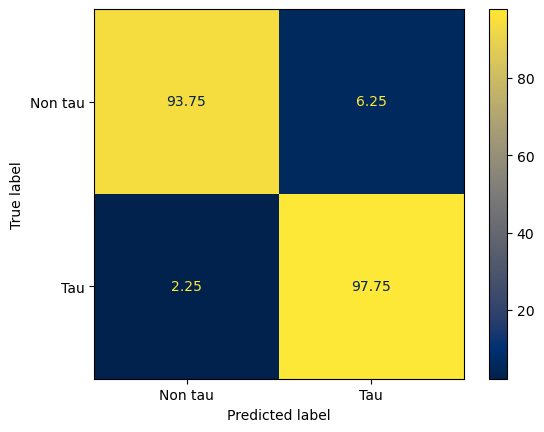

In [17]:
plot = ConfusionMatrixDisplay(final_cm,
                              display_labels=['Non tau','Tau'])
plot.plot(cmap='cividis', values_format='.2f')         
plt.show()

In [29]:
model = loaded_model
# Confusion matrix across 10 folds, WITH thresholding 
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)
print('Macro avg F1 std ', 
      np.std([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)

print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print('Macro avg precision std',
      np.std([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reportsT])*100)
print('Macro avg recall std',
      np.std([i['macro avg']['recall'] for i in model.cv_reportsT])*100)

Macro avg F1  95.35360503169731
Macro avg F1 std  6.42426370314774
--------------------------
Macro avg precision 95.95762879595841
Macro avg precision std 4.638853604164306
--------------------------
Macro avg recall  95.64416479655493
Macro avg recall std 5.736505756683469


In [30]:
model = loaded_model
# Confusion matrix across 10 folds, WITH NO thresholding 
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reports])*100)
print('Macro avg F1 std ', 
      np.std([i['macro avg']['f1-score'] for i in model.cv_reports])*100)

print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reports])*100)
print('Macro avg precision std',
      np.std([i['macro avg']['precision'] for i in model.cv_reports])*100)
print("--------------------------")
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reports])*100)
print('Macro avg recall std',
      np.std([i['macro avg']['recall'] for i in model.cv_reports])*100)

Macro avg F1  95.50643809603123
Macro avg F1 std  5.956351702881871
--------------------------
Macro avg precision 96.03637053346722
Macro avg precision std 4.432265618362454
--------------------------
Macro avg recall  95.75315647997682
Macro avg recall std 5.307869903914251


In [20]:
# calculate accuracy in percentages of all confusion matrices and put in a list 
percent_cm = []
for i in loaded_model.cv_confusion_matrices:
    x = i.astype('float') / i.sum(axis=1)[:, np.newaxis]*100
    percent_cm.append(x)

nt_nt = [i[0][0] for i in percent_cm]
nt_t = [i[0][1] for i in percent_cm]
t_nt = [i[1][0] for i in percent_cm]
t_t = [i[1][1] for i in percent_cm]

# Calculate mean accuracy per category
print('mean accuracy ')
print(mean(nt_nt))
print(mean(nt_t))
print(mean(t_nt))
print(mean(t_t))

# Calculate std of accuracies 
print('std accuracy ')
print(np.std(nt_nt))
print(np.std(nt_t))
print(np.std(t_nt))
print(np.std(t_t))
    

mean accuracy 
93.75490563419373
6.245094365806271
2.2485926742400855
97.75140732575991
std accuracy 
11.075029863052457
11.075029863052457
0.8609636351019537
0.860963635101954


Plotting feature importance

In [8]:
import seaborn as sns

In [21]:
model_rf = joblib.load('/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Tuning_parameters/Final/results/screening_random_search_updated3.sav')

In [22]:
model_rf.best_params_

{'selector__n_features_to_select': 46,
 'clf__sampling_strategy': 'auto',
 'clf__random_state': 42,
 'clf__n_estimators': 600,
 'clf__min_samples_split': 2,
 'clf__min_samples_leaf': 2,
 'clf__max_samples': None,
 'clf__max_features': 1,
 'clf__max_depth': None,
 'clf__class_weight': 'balanced'}

In [23]:
#With feature selection
rf_result = model_rf.best_estimator_.named_steps['selector'].get_support(indices=True)
rf_result
rf_result_f = [s_data.c1_X_train.columns[i] for i in rf_result]
# (rf_result_f)
importance = model_rf.best_estimator_.named_steps['clf'].feature_importances_
f_importance = pd.DataFrame(data={'features':rf_result_f,'importance':importance})
f_importance = f_importance.sort_values(by=['importance'],ascending=False)

In [24]:
f_importance_subset = f_importance[0:11]
features = [i.replace('ROI: 0.25 µm per pixel: ','') for i in f_importance_subset['features']]
f_importance_subset = f_importance_subset.copy()
f_importance_subset.loc[:,'features'] = features
f_importance_subset = f_importance_subset.rename(columns={'features':'Feature',
                                    'importance':'Importance'})

In [27]:
f_importance_subset

,Feature,Importance
33,Hematoxylin: Mean,0.043437
34,Hematoxylin: Median,0.041947
37,Red: Mean,0.038536
36,Red: Max,0.036822
19,DAB: Haralick Sum average (F5),0.034232
24,DAB: Mean,0.033630
35,Hematoxylin: Min,0.030751
38,Red: Median,0.030750
27,DAB: Std.dev.,0.030701
25,DAB: Median,0.030683


<Axes: xlabel='Importance', ylabel='Feature'>

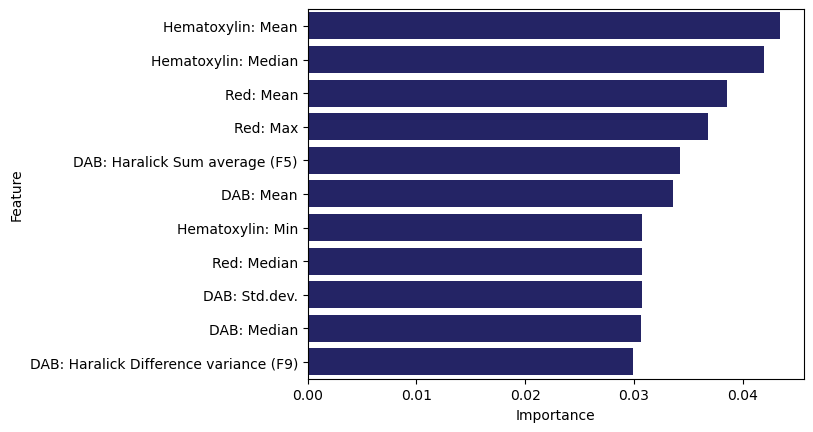

In [25]:
sns.barplot(data=f_importance_subset,
            y="Feature",
            x="Importance",
            color='midnightblue')

Finding PR-AUC

In [31]:
keys = ['split0_test_PR_AUC',
        'split1_test_PR_AUC',
        'split2_test_PR_AUC',
        'split3_test_PR_AUC',
        'split4_test_PR_AUC',
        'split5_test_PR_AUC',
        'split6_test_PR_AUC',
        'split7_test_PR_AUC',
        'split8_test_PR_AUC',
        'split9_test_PR_AUC']
pr_val = []
for i in keys:
    pr_val.append(model_rf.cv_results_[i][model_rf.best_index_])

In [32]:
print(model_rf.cv_results_['mean_test_PR_AUC'][model_rf.best_index_])
print('mean pr:', mean(pr_val)*100)
print('std pr:', np.std(pr_val)*100)

0.9911478458271097
mean pr: 99.11478458271097
std pr: 1.1493303596250326
